# Основы Lasagne CNN

In [1]:
import numpy as np
import theano
import theano.tensor as T

http://deeplearning.net/software/theano/

In [2]:
import lasagne

http://lasagne.readthedocs.io/en/latest/

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

http://matplotlib.org/gallery.html

In [4]:
import gzip
import pickle

https://docs.python.org/2/library/gzip.html

https://docs.python.org/2/library/pickle.html

## Скачиваем набор данных MNIST

In [5]:
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2016-11-23 12:02:10--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘mnist.pkl.gz’ not modified on server. Omitting download.



## Загружаем данные

In [6]:
train, val, test = pickle.load(gzip.open('mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

## Создаём функцию генерации минибатчей

In [7]:
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

## Создаём нейросеть, содержащую один свёрточный слой и один полносвязный

In [8]:
l_in = lasagne.layers.InputLayer((None, 784))

l_shape = lasagne.layers.ReshapeLayer(l_in, (-1, 1, 28, 28))

l_conv = lasagne.layers.Conv2DLayer(l_shape, num_filters=3, filter_size=3, pad=1)

l_out = lasagne.layers.DenseLayer(l_conv,
                                  num_units=10,
                                  nonlinearity=lasagne.nonlinearities.softmax)

### Символьные переменные для признаков и меток

In [9]:
X_sym = T.matrix()
y_sym = T.ivector()

### Получаем предсказание модели

In [10]:
output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

## Определяем целевую функцию

In [11]:
loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))
acc = T.mean(T.eq(pred, y_sym))

## Находим производные функции потерь по все параметрам модели

In [12]:
params = lasagne.layers.get_all_params(l_out)
grad = T.grad(loss, params)

## В качестве метода оптимизации выбираем Adam с LL = 0.005

In [13]:
updates = lasagne.updates.adam(grad, params, learning_rate=0.005)

### Создаём функцию обучения, валидации и предсказания

In [14]:
f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])
f_predict = theano.function([X_sym], pred)

## Устанавливаем параметры обучения модели для каждой эпохи

In [15]:
BATCH_SIZE = 64
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

### Создаём минибатчи для обучения и валидации

In [16]:
train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

# Обучение модели

In [17]:
for epoch in range(5):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch 0, Train (val) loss 0.255 (0.153) ratio 0.598
Train (val) accuracy 0.925 (0.957)
Epoch 1, Train (val) loss 0.113 (0.128) ratio 1.135
Train (val) accuracy 0.966 (0.966)
Epoch 2, Train (val) loss 0.084 (0.109) ratio 1.306
Train (val) accuracy 0.975 (0.972)
Epoch 3, Train (val) loss 0.067 (0.112) ratio 1.686
Train (val) accuracy 0.980 (0.971)
Epoch 4, Train (val) loss 0.058 (0.098) ratio 1.698
Train (val) accuracy 0.983 (0.974)


## Что же получается на выходе слоя свёртки?

### Создаём функцию для получения результата из свёрточного слоя

In [22]:
filtered = lasagne.layers.get_output(l_conv, X_sym)
f_filter = theano.function([X_sym], filtered)

### Возьмём первые 10 изображений из минибатча

In [23]:
im = f_filter(X_train[:10])
print(im.shape)

(10, 3, 28, 28)


### Объединяем результаты для получения RGB изображения

In [20]:
im = np.rollaxis(np.rollaxis(im, 3, 1), 3, 1)

### Визуализируем полученный результат

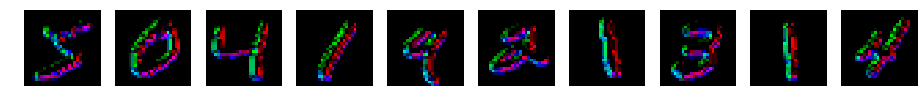

In [21]:
plt.figure(figsize=(16,8))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(im[i], interpolation='nearest')
    plt.axis('off')